In [2]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import Huber
from keras.regularizers import l2
from keras.metrics import MeanSquaredError, MeanAbsoluteError,RootMeanSquaredError
from keras import Sequential, layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

2024-08-17 21:21:30.989525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 21:21:30.989624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 21:21:31.149028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Hyper parameters
PATCH_SIZE = 16
BATCH_SIZE = 200
EPOCHS = 80
DROPOUT_RATE = 0.5
L2_RATE = 1e-3

In [4]:
val_files = {
    "../patches-16/skull_decimated.npy", 
    "../patches-16/ant_decimated.npy", 
    "../patches-16/vase_decimated.npy", 
    "../patches-16/isis_decimated.npy", 
    "../patches-16/teddy_decimated.npy",
    "../patches-16/teapot_decimated.npy"
}

patche_files = sorted(glob.glob('../patches-16/*.npy'))
patche_files = list(set(patche_files) - val_files)
saliency_files = [
    f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}" 
    for f in patche_files
]

print('Number of patches:', len(patche_files))
print('Number of saliency maps:', len(saliency_files))

Number of patches: 43
Number of saliency maps: 43


In [5]:
X_train = np.concatenate([np.load(f, mmap_mode="r").astype(np.float32) for f in patche_files])
y_train = np.concatenate([np.loadtxt(f).astype(np.float32) for f in saliency_files])
    
X_train, y_train = shuffle(X_train, y_train)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((859999, 16, 16, 3), (859999,), dtype('float32'), dtype('float32'))

In [6]:
# Define the CNN model
model = Sequential()

# Convolutional layers with L2 regularization
model.add(layers.Conv2D(32, (3, 3), padding="same", strides=(1, 1), activation="relu",
                        kernel_regularizer=l2(L2_RATE), input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

model.add(layers.Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation='relu',
                       kernel_regularizer=l2(L2_RATE)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

model.add(layers.Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation='relu',
                       kernel_regularizer=l2(L2_RATE)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

# Flatten the output from convolutional layers
model.add(layers.Flatten())

# Dense layers with L2 regularization
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_RATE)))
model.add(layers.Dropout(DROPOUT_RATE))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_RATE)))
model.add(layers.Dropout(DROPOUT_RATE))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=Huber(),
              metrics=[
                  MeanSquaredError(name='mse'),
                  MeanAbsoluteError(name='mae'),
                  RootMeanSquaredError(name='rmse'),
              ])

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,521 (1.11 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
# fit the model
saliency_model = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/80
  30/3440 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.8036 - mae: 0.2601 - mse: 0.1521 - rmse: 0.3779

I0000 00:00:1723929746.421128      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723929746.445777      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3150 - mae: 0.1005 - mse: 0.0340 - rmse: 0.1828

W0000 00:00:1723929764.432118      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 0.3150 - mae: 0.1005 - mse: 0.0340 - rmse: 0.1828 - val_loss: 0.0159 - val_mae: 0.0958 - val_mse: 0.0260 - val_rmse: 0.1611 - learning_rate: 1.0000e-04
Epoch 2/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0149 - mae: 0.0963 - mse: 0.0258 - rmse: 0.1608 - val_loss: 0.0142 - val_mae: 0.0971 - val_mse: 0.0264 - val_rmse: 0.1625 - learning_rate: 1.0000e-04
Epoch 3/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0134 - mae: 0.0945 - mse: 0.0250 - rmse: 0.1581 - val_loss: 0.0135 - val_mae: 0.0925 - val_mse: 0.0254 - val_rmse: 0.1593 - learning_rate: 1.0000e-04
Epoch 4/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0131 - mae: 0.0939 - mse: 0.0248 - rmse: 0.1574 - val_loss: 0.0137 - val_mae: 0.0960 - val_mse: 0.0260 - val_rmse: 0.1614 - learning_rate: 1.0000e-04
Epoch 5/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0130 - mae: 0.0937 - mse: 0.0247 - rmse: 0.1570 - val_loss: 0.0132 - val_mae: 0.0893 -

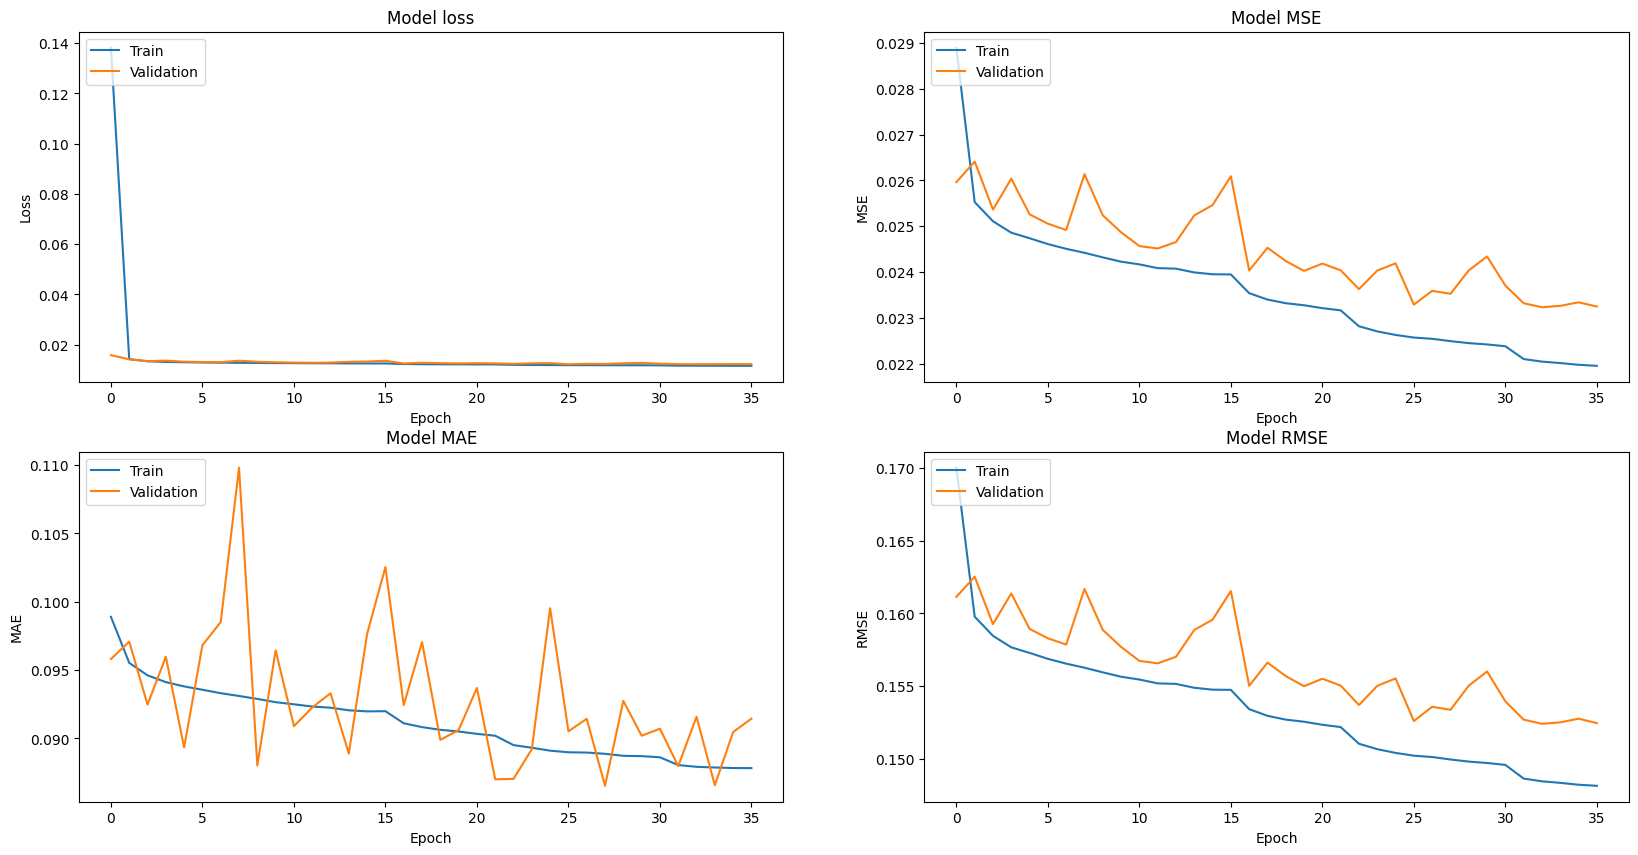

In [9]:
plt.figure(figsize=(20, 10))
# Plot the training and validation loss
plt.subplot(2, 2, 1)
plt.plot(saliency_model.history['loss'][0:])
plt.plot(saliency_model.history['val_loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(saliency_model.history['mse'][0:])
plt.plot(saliency_model.history['val_mse'][0:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(saliency_model.history['mae'][0:])
plt.plot(saliency_model.history['val_mae'][0:])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(saliency_model.history['rmse'][0:])
plt.plot(saliency_model.history['val_rmse'][0:])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
model.save('../saved-models/optimized-model-16.h5')

In [11]:
import gc
del X_train 
del y_train
gc.collect()

15721

In [12]:
# evaluate model
X_test = np.concatenate([np.load(f).astype(np.float32) for f in val_files])
y_test = np.concatenate([np.loadtxt(f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}").astype(np.float32) for f in val_files])
loss, mse, mae, rmse = model.evaluate(X_test, y_test, verbose=1)
print("Loss: ", loss)
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0096 - mae: 0.0839 - mse: 0.0181 - rmse: 0.1340
Loss:  0.008612141013145447
MSE:  0.016071069985628128
MAE:  0.07842794060707092
RMSE:  0.1267717182636261
